In [1]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error 

warnings.filterwarnings("ignore")

In [2]:
brewing_material = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-31/brewing_materials.csv')
beer_taxed = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-31/beer_taxed.csv')
brewer_size = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-31/brewer_size.csv')
beer_states = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-31/beer_states.csv')

In [3]:
beer_taxed

,data_type,tax_status,year,month,type,month_current,month_prior_year,ytd_current,ytd_prior_year,tax_rate
0,Barrels Produced,Totals,2008,1,Production,16211480,15880125,16211480.0,15880125.0,$7/$18 per barrel
1,Barrels Produced,Taxable,2008,1,In bottles and cans,13222104,12824278,13222104.0,12824278.0,$7/$18 per barrel
2,Barrels Produced,Taxable,2008,1,In barrels and kegs,1371239,1357372,1371239.0,1357372.0,$7/$18 per barrel
3,Barrels Produced,Taxable,2008,1,"Tax Determined, Premises Use",7426,8419,7426.0,8419.0,$7/$18 per barrel
4,Barrels Produced,Sub Total Taxable,2008,1,Sub Total Taxable,14600769,14190069,14600769.0,14190069.0,$7/$18 per barrel
...,...,...,...,...,...,...,...,...,...,...
1575,Barrels Produced,Tax Free,2019,12,For vessels and aircraft,1,2,34440.0,2633.0,$3.50/$16 per barrel
1576,Barrels Produced,Tax Free,2019,12,Consumed on brewery premises,23886,30149,115240.0,123207.0,$3.50/$16 per barrel
1577,Barrels Produced,Sub Total Tax-Free,2019,12,Sub Total Tax-Free,384956,389456,5216540.0,7035336.0,$3.50/$16 per barrel
1578,Barrels Produced,Totals,2019,12,Total Removals,14210261,13507134,172293772.0,174239390.0,$3.50/$16 per barrel


# Data Preprocessing 

In [4]:
df = beer_taxed[beer_taxed["type"] == "Production"]

In [5]:
df.loc[:,'Date'] = pd.to_datetime(df.year.astype(str)+' '+df.month.astype(str))

In [6]:
df = df.set_index("Date")


In [7]:
df = df.drop(columns= ["year", "month", "data_type", "type", "month_prior_year", "ytd_current", "ytd_prior_year", "tax_rate", "tax_status"])

In [8]:
df.rename(columns={'month_current': 'values'}, inplace=True)

In [9]:
df

,values
Date,
2008-01-01,16211480
2008-02-01,15690494
2008-03-01,17367476
2008-04-01,17254160
2008-05-01,18269043
...,...
2019-08-01,15359693
2019-09-01,15378683
2019-10-01,14344526


In [10]:
date = df.index
target = df.values

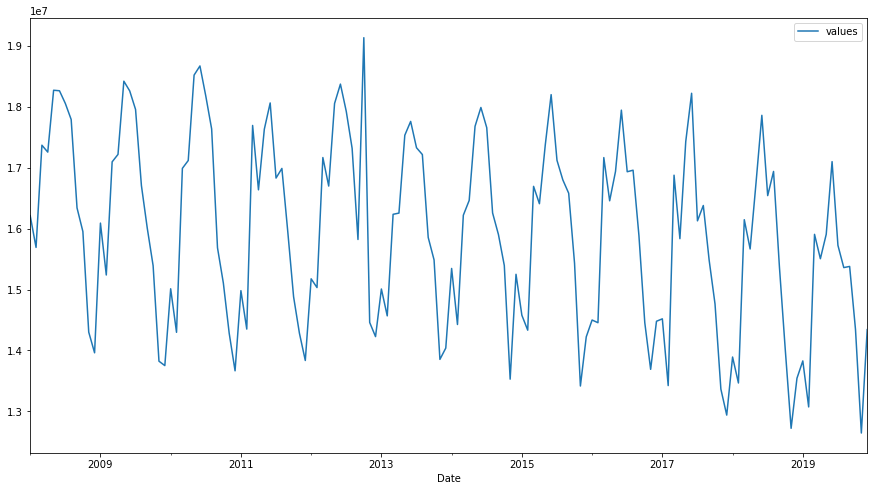

In [11]:
df.plot(figsize = (15,8))
plt.show()

## Seasonality decomposition

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. p-value > 0.05.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. p-value <= 0.05.



In [12]:
def dickeyFuller(df,target):
    
    # Applying Dickey Fuller Test
    X = df.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
           print('\t%s: %.3f' % (key, value))
    
    
    # Decomposing Seasonality if it exists
    if result[0]>0:
        df[target] = df[target].rolling(12).mean()
    
    return df

In [13]:
df = dickeyFuller(df,target)

ADF Statistic: -0.275174
p-value: 0.928948
Number of lags used: 13
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


p-value: 0.928948 -->

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

Ok to go. 

### Autocorrelation Plot

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 
The plot shows the value of the autocorrelation function (acf) on the vertical axis ranging from –1 to 1.
There are vertical lines (a “spike”) corresponding to each lag and the height of each spike shows the value of the autocorrelation function for the lag.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

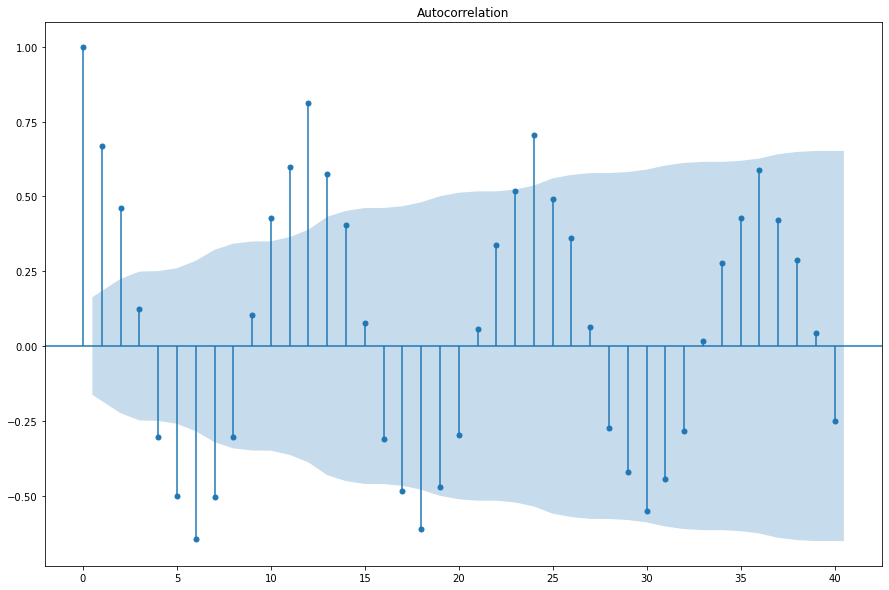

In [14]:
x = plot_acf(df, lags=40)
x.set_size_inches(15, 10, forward=True)
plt.show()

### Partial Autocorrelation Plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. By examining the spikes at each lag we can determine whether they are significant or not. A significant spike will extend beyond the significant limits, which indicates that the correlation for that lag doesn't equal zero.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)

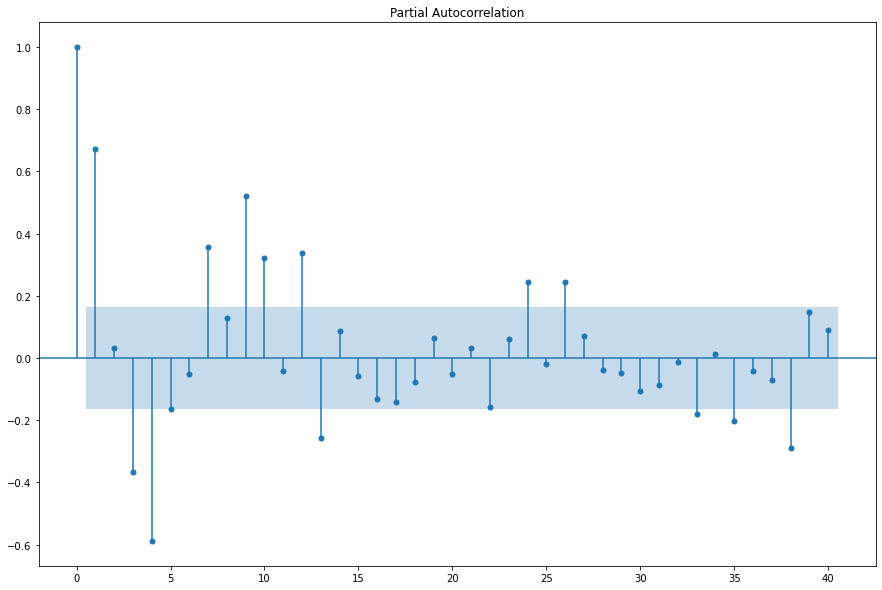

In [15]:
y = plot_pacf(df, lags=40)
y.set_size_inches(15, 10, forward=True)
plt.show()

As it's shown in the autocorrelation plot, in most of the elements in the time series, the "spikes" go over the treshold, meaning that, up to lag 27 aproximately, the autocorrelation is significant. As well, it's clear that the autocorrelation is positive in some lags and negative in others. This could be explained due to the seasonality of beer production evidenced in previous figures. 

### Data Splitting

Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [16]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

### Model

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.
FOR MORE INFO: [API](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

In [22]:
model=ARIMA(df["values"],order=(1, 0, 0))
result=model.fit()

In [23]:
d = df.drop(["values"], axis = 1)

start_date = d.iloc[size].name
end_date = d.iloc[len(df)-1].name

df_pred = result.predict(start = start_date, end = end_date)
df_pred.head()

2018-10-01    1.555959e+07
2018-11-01    1.465200e+07
2018-12-01    1.378758e+07
2019-01-01    1.433616e+07
2019-02-01    1.452610e+07
Freq: MS, dtype: float64

In [24]:
test = df_test["values"]
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(test,df_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(test,df_pred)))
print("Root Mean Squared Error {:.2f}".format(np.sqrt(mean_squared_error(test,df_pred))))

Mean Absolute Error 1002921.48
Mean Squared Error 1446078094080.06
Root Mean Squared Error 1202529.87


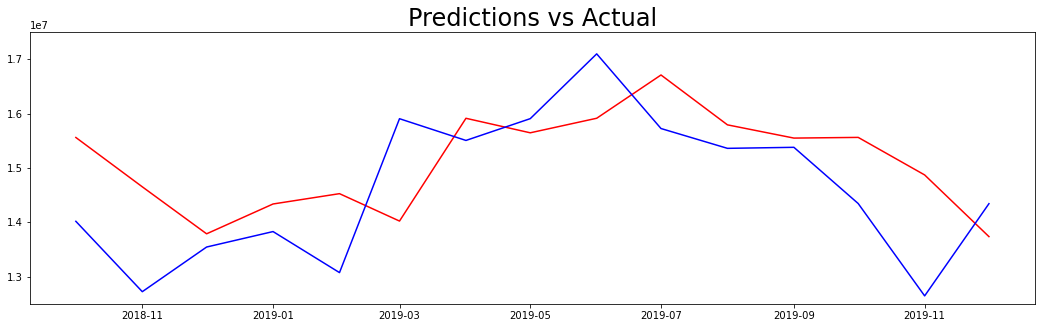

In [55]:
plt.figure(figsize=(18,5))
plt.plot(df_pred[start_date:end_date], color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")
#plt.axis([1, 12 , 14000000, 16000000])
plt.ylim(12500000, 17500000)


plt.show()

Not the best but still a good forecast that responds to seasonal changes